MLP FOR A BINARY CLASSIFICATION PROBLEM: Physical or Non physical matrix?

The goal is to descriminate between matrices that are physical, i.e. that represent a quantum state, or matrices that are not physical. I use matrix with all the same size, associated to an Hilbert Space Dimension of 4: 4x4 matrices, i.e. 16 complex elements in each matrix.
I generated 300 physical and 300 non physical matrices through a MATLAB code (Dataset_creation.m) that I wrote. A physical matrix, also called Density matrix, must satisfy three requirements: it must be positive definite, hermitian, with trace equal to 1. In order to obtain this, in the MATLAB code, I first randomly generate 4x4 complex matrices. Each element of these matrices has real and imaginary part randomly extracted from a uniform distribution in the interval (-1,1). Then, I make matrices symmetric, with real diagonal values. To obtain positive definite matrices I use the Modified Cholesky Factorization. I found on internet a MATLAB code to implement this factorization (modchol_ldlt.m), for this I chose to generate matrices in MATLAB. Finally, I make matrices hermitian, and I normalize them to obtain trace equal to 1.
I also created non physical matrices. From these we can found: 75 randomly generated complex matrices, 75 positive definite complex matrices, 75 positive definite and hermitian matrices and 75 positive definite matrices with trace equal to 1.
I reshape each generated matrix in a row vector of shape (1x16). From the MATLAB code I saved real and imaginary part of Physical and Non Physical matrices in four '.txt' files. Each row of files represents a different matrix, the columns are real or imaginary matrices' elements. This is the starting point to build my dataset. I will build the dataset in this code.

I choose label 0 to classify Physical matrices, label 1 to classify Non Physical matrices.

First, I will implement a Multilayer Perceptron to solve the classification problem.

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import cmath

DATASET CREATION

To create the dataset, first I import the generated data in MATLAB. I arranged the dataset matrix in a way that each row constitutes a different physical or non physical matrix. Each matrix (row) has 32 features that are the real and imaginary part of the elements of the matrix. The first 16 features are the real part of each element of the matrix, while the other 16 features are the imaginary part. The dataset has dimension (600,33) where the last column represents the label of the belonging class (0 or 1).

In [29]:
#import data generated in MATLAB
physical_real=np.loadtxt(r'/content/300_Physical_matrices_Dim=4_RealPart.txt')
Non_physical_real=np.loadtxt(r'/content/300_Non_Physical_matrices_Dim=4_RealPart.txt')
physical_imag=np.loadtxt(r'/content/300_Physical_matrices_Dim=4_ImagPart.txt')
Non_physical_imag=np.loadtxt(r'/content/300_Non_Physical_matrices_Dim=4_ImagPart.txt')

################ TO CREATE THE DATASET #############

#Classifier: 0-> Physical matrix, 1-> Non physical matrix
target_Physical=np.zeros((physical_real.shape[0],1),dtype=int)
target_NonPhysical=np.ones((physical_real.shape[0],1),dtype=int)

Physical_data=np.concatenate((physical_real,physical_imag,target_Physical), axis=1)
NonPhysical_data=np.concatenate((Non_physical_real,Non_physical_imag,target_NonPhysical), axis=1)
#print("Physical data size:  ", Physical_data.shape, ", Non Physical data size: ", NonPhysical_data.shape)

dataset=np.concatenate((Physical_data,NonPhysical_data), axis=0)
np.random.shuffle(dataset)
print("Dataset dimension", dataset.shape)

features=dataset[:,:-1]
target=dataset[:,dataset.shape[1]-1]
print("features size: ", features.shape, ", target size: ", target.shape)



Dataset dimension (600, 33)
features size:  (600, 32) , target size:  (600,)


Now, I can split the dataset in train and validation set, with a ratio of 2:1

In [30]:
from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val = train_test_split(features, target, test_size=0.33, shuffle=False)
print("X_train: ",X_train.shape,", X_val: " ,X_val.shape, ", Y_train: ", Y_train.shape, ", Y_val: ",Y_val.shape)


X_train:  (402, 32) , X_val:  (198, 32) , Y_train:  (402,) , Y_val:  (198,)


BUILDING THE MLP MODEL

In [31]:
# keras imports
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Dropout, Flatten, Activation
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K
from tensorflow.keras import metrics
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TerminateOnNaN

In [32]:
input_shape = X_train.shape[1]
dropoutRate = 0.25


In [57]:
inputArray = Input(shape=(input_shape,))

#FIRST LAYER
x = Dense(40, activation='relu')(inputArray)
x = Dropout(dropoutRate)(x)

#SECOND LAYER
x = Dense(30, activation='relu')(inputArray)


output=Dense(1, activation='sigmoid')(x)

model = Model(inputs=inputArray, outputs=output)

In [58]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 32)]              0         
                                                                 
 dense_20 (Dense)            (None, 30)                990       
                                                                 
 dense_21 (Dense)            (None, 1)                 31        
                                                                 
Total params: 1,021
Trainable params: 1,021
Non-trainable params: 0
_________________________________________________________________


In [61]:
batch_size = 20
n_epochs = 250

# train
history = model.fit(X_train, Y_train, epochs=n_epochs, batch_size=batch_size, verbose = 2,
                validation_data=(X_val, Y_val),
                callbacks = [
                EarlyStopping(monitor='val_loss', patience=20, verbose=1),
                ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1),
                TerminateOnNaN()])

_, train_acc = model.evaluate(X_train, Y_train, verbose=0)
_, val_acc = model.evaluate(X_val, Y_val, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, val_acc))

Epoch 1/250
21/21 - 0s - loss: 0.2956 - accuracy: 0.8781 - val_loss: 0.3844 - val_accuracy: 0.8434 - 136ms/epoch - 6ms/step
Epoch 2/250
21/21 - 0s - loss: 0.2956 - accuracy: 0.8781 - val_loss: 0.3844 - val_accuracy: 0.8434 - 97ms/epoch - 5ms/step
Epoch 3/250
21/21 - 0s - loss: 0.2956 - accuracy: 0.8781 - val_loss: 0.3844 - val_accuracy: 0.8434 - 85ms/epoch - 4ms/step
Epoch 4/250
21/21 - 0s - loss: 0.2956 - accuracy: 0.8781 - val_loss: 0.3844 - val_accuracy: 0.8434 - 94ms/epoch - 4ms/step
Epoch 5/250
21/21 - 0s - loss: 0.2956 - accuracy: 0.8781 - val_loss: 0.3844 - val_accuracy: 0.8434 - 95ms/epoch - 5ms/step
Epoch 6/250
21/21 - 0s - loss: 0.2956 - accuracy: 0.8781 - val_loss: 0.3844 - val_accuracy: 0.8434 - 135ms/epoch - 6ms/step
Epoch 7/250
21/21 - 0s - loss: 0.2956 - accuracy: 0.8781 - val_loss: 0.3844 - val_accuracy: 0.8434 - 117ms/epoch - 6ms/step
Epoch 8/250
21/21 - 0s - loss: 0.2956 - accuracy: 0.8781 - val_loss: 0.3844 - val_accuracy: 0.8434 - 94ms/epoch - 4ms/step
Epoch 9/250
2

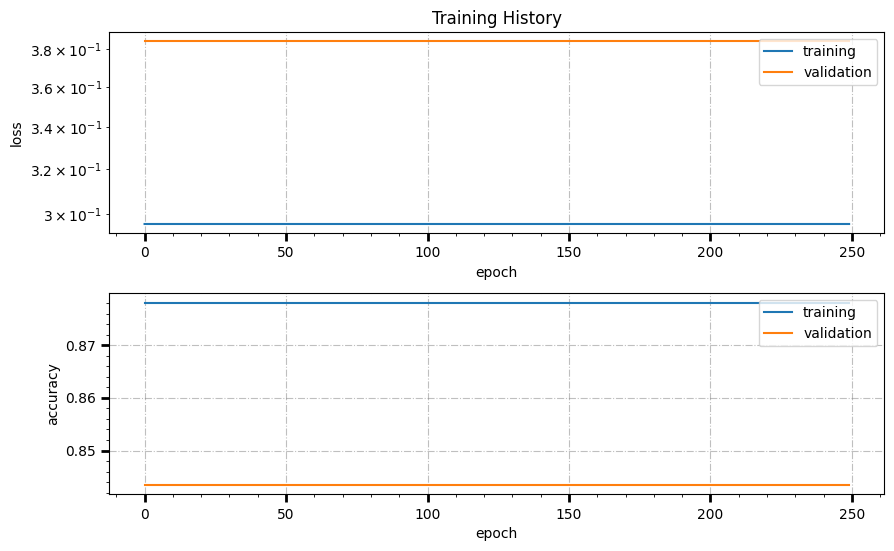

In [62]:
# plot training history

fig, ((ax0,ax1)) = plt.subplots(figsize=(10, 6), ncols=1, nrows=2)
for ax in fig.get_axes():
  ax.minorticks_on()
  ax.tick_params(axis='x', which='both', direction='out')
  ax.grid(True,which='major', axis='both',linestyle='-.') #see https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.grid.html#matplotlib.axes.Axes.grid
  #ax.tick_params(which='major',labelcolor='b', labelsize='small', width=2) #https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.tick_params.html#matplotlib.axes.Axes.tick_params
  ax.tick_params(direction='out', length=6, width=2, colors='k',grid_color='gray', grid_alpha=0.5)

plt.subplots_adjust(hspace=0.3, wspace=0.3)

ax0.plot(history.history['loss'])
ax0.plot(history.history['val_loss'])
ax0.set_yscale('log')
ax0.set_title('Training History')
ax0.set_ylabel('loss')
ax0.set_xlabel('epoch')
ax0.legend(['training', 'validation'], loc='upper right')

ax1.plot(history.history['accuracy'])
ax1.plot(history.history['val_accuracy'])
ax1.set_ylabel('accuracy')
ax1.set_xlabel('epoch')
ax1.legend(['training', 'validation'], loc='upper right')
plt.show()

7/7 [==============================] - 0s 3ms/step


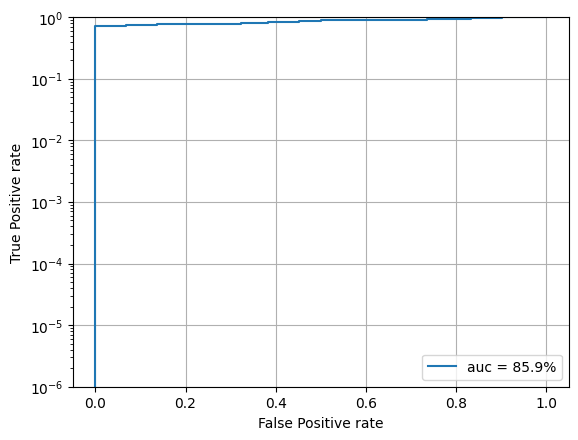

In [66]:
labels = ['Physical Matrix', 'Non Physical Matrix']

import pandas as pd
from sklearn.metrics import roc_curve, auc
predict_val = model.predict(X_val)
df = pd.DataFrame()

plt.figure()

fpr, tpr, threshold = roc_curve(Y_val,predict_val) #per fare la curva ROC
auc1= auc(fpr, tpr) #calcolo AUC che mi dice quanto è buono il mio modello (calcola l'area sotto la ROC curve)

plt.plot(fpr,tpr,label='auc = %.1f%%'%(auc1*100.))
plt.semilogy()
plt.xlabel("False Positive rate")
plt.ylabel("True Positive rate")
plt.ylim(0.000001,1)
plt.grid(True)
plt.legend(loc='lower right')
plt.show()